In [1]:
import graphviz
import numpy as np
import pandas as pd
from collections import OrderedDict
from sortedcollections import OrderedSet

path = set()

In [2]:
start = 'A'
V = 'ABCDEFGH'
edges = {
    ('A', 'B'): 8,
    ('A', 'C'): 2,
    ('A', 'D'): 5,
    ('B', 'D'): 2,
    ('C', 'D'): 2,
    ('C', 'E'): 5,
    ('B', 'F'): 13,
    ('D', 'F'): 6,
    ('D', 'E'): 1,
    ('D', 'G'): 3,
    ('E', 'G'): 1,
    ('G', 'F'): 2,
    ('G', 'H'): 6,
    ('F', 'H'): 3,
}

# start = 'u'
# V = 'uvwxyz'
# edges = {
#     ('u', 'w'): 7,
#     ('u', 'v'): 2,
#     ('u', 'x'): 1,
#     ('v', 'x'): 1,
#     ('v', 'w'): 5,
#     ('x', 'w'): 4,
#     ('x', 'y'): 5,
#     ('w', 'z'): 8,
#     ('w', 'y'): 2,
#     ('y', 'z'): 9,
# }

In [3]:
def check_valid_spanning_tree(graph):
    G = {n: set(v for u, v in graph if u == n) for n in V}
    stack, visited = list(start), set()

    def dfs():
        while stack:
            visited.add(n := stack.pop())
            stack.extend(G[n])
            if any(n in visited for n in stack):
                raise Exception("cycle found")
        if visited != set(V):
            raise Exception(f"nodes {set(V) - visited} were not connected")

    try:
        dfs()
    except Exception as err:
        print(err)

In [4]:
# modified from \ref{https://stackoverflow.com/questions/1456373/two-way-reverse-map}
class BiDict(OrderedDict):
    def __setitem__(self, key: tuple, value):
        if key in self:
            del self[key]

        OrderedDict.__setitem__(self, key, value)
        OrderedDict.__setitem__(self, key[::-1], value)
        
    def __delitem__(self, key):
        OrderedDict.__delitem__(self, key)
        OrderedDict.__delitem__(self, key[::-1])

E = BiDict(**edges)

In [5]:
lookup = OrderedDict({u: OrderedDict({v: E.get((u, v), np.inf) for v in sorted(set(V) - set(u))}) for u in sorted(V)})

In [6]:
class Node:
    def __init__(self, value, dist=0, prev=None):
        self.value = value
        self.dist = dist   # the estimate distance (cost) value from the initiator
        self.prev = prev   # predecessor node in the spanning tree rooted at the initiator

    def __repr__(self):
        return self.value

    def __str__(self):
        return str(np.inf) if self.dist == np.inf else f"{self.dist},{self.prev.value}"

    def __getitem__(self, q):
        """Returns the dist p to q if connected; otherwise, infinity"""
        return lookup[self.value][q.value]

In [7]:
initiator = Node(value=start)
graph = OrderedSet(map(lambda u: Node(value=u, dist=lookup[start][u], prev=initiator), sorted(set(V) - set(start))))
visited = OrderedSet({initiator})

headers = [(f"D({start}),p({start})", [f'0,{start}'])] + [(f"D({u.value}),p({u.value})", [str(u)]) for u in graph]
table = OrderedDict([("N'", [start]), *headers])

# print(f"Graph: {graph}", f"Visited: {visited}", f"Table: {table}", sep='\n')

In [8]:
for _ in range(1, len(V)):
    # NOTE: Python's min() function always selects the first occurrence if values are equal
    # So, if the algorithm encounters two paths from p to q with the same dist/cost,
    # q's prev won't change; thus, the route/path from p to q won't change either
    p = min(graph-visited, key=lambda u: u.dist)

    visited.add(p)
    path.add((p.prev.value, p.value))  # used for graphviz
    
    table["N'"].append(''.join(map(repr, visited)))

    for q in graph-visited:
        print(f"D({q.value}) = min(D({q.value}), D({p.value}) + C({p.value}, {q.value})) =",
              f"min({q.dist}, {p.dist} + {p[q]}) =",
              f"min({q.dist}, {p.dist + p[q]}) =",
              min(q.dist, p.dist + p[q]))

        if p.dist + p[q] < q.dist:
            q.dist = p.dist + p[q]
            q.prev = p

        table[f"D({q.value}),p({q.value})"].append(str(q))

D(B) = min(D(B), D(C) + C(C, B)) = min(8, 2 + inf) = min(8, inf) = 8
D(D) = min(D(D), D(C) + C(C, D)) = min(5, 2 + 2) = min(5, 4) = 4
D(E) = min(D(E), D(C) + C(C, E)) = min(inf, 2 + 5) = min(inf, 7) = 7
D(F) = min(D(F), D(C) + C(C, F)) = min(inf, 2 + inf) = min(inf, inf) = inf
D(G) = min(D(G), D(C) + C(C, G)) = min(inf, 2 + inf) = min(inf, inf) = inf
D(H) = min(D(H), D(C) + C(C, H)) = min(inf, 2 + inf) = min(inf, inf) = inf
D(B) = min(D(B), D(D) + C(D, B)) = min(8, 4 + 2) = min(8, 6) = 6
D(E) = min(D(E), D(D) + C(D, E)) = min(7, 4 + 1) = min(7, 5) = 5
D(F) = min(D(F), D(D) + C(D, F)) = min(inf, 4 + 6) = min(inf, 10) = 10
D(G) = min(D(G), D(D) + C(D, G)) = min(inf, 4 + 3) = min(inf, 7) = 7
D(H) = min(D(H), D(D) + C(D, H)) = min(inf, 4 + inf) = min(inf, inf) = inf
D(B) = min(D(B), D(E) + C(E, B)) = min(6, 5 + inf) = min(6, inf) = 6
D(F) = min(D(F), D(E) + C(E, F)) = min(10, 5 + inf) = min(10, inf) = 10
D(G) = min(D(G), D(E) + C(E, G)) = min(7, 5 + 1) = min(7, 6) = 6
D(H) = min(D(H), D(E)

In [9]:
for entry in table.values():
    entry.extend(['---'] * (len(V)-len(entry)))

In [10]:
check_valid_spanning_tree(path)

In [11]:
print(pd.DataFrame(table).to_markdown(tablefmt="rounded_grid"))

╭────┬──────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────┬─────────────╮
│    │ N'       │ D(A),p(A)   │ D(B),p(B)   │ D(C),p(C)   │ D(D),p(D)   │ D(E),p(E)   │ D(F),p(F)   │ D(G),p(G)   │ D(H),p(H)   │
├────┼──────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  0 │ A        │ 0,A         │ 8,A         │ 2,A         │ 5,A         │ inf         │ inf         │ inf         │ inf         │
├────┼──────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  1 │ AC       │ ---         │ 8,A         │ ---         │ 4,C         │ 7,C         │ inf         │ inf         │ inf         │
├────┼──────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│  2 │ ACD      │ ---         │ 6,D         │ ---         │ ---         │ 5,D         │ 10

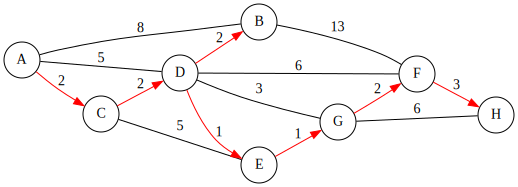

In [12]:
sptree = graphviz.Graph("Dijkstra's Link State Algorithm",
                        filename='spanning_tree',
                        graph_attr={'rankdir': 'LR'},
                        node_attr={'shape': 'circle'})

[sptree.node(v) for v in V]
[sptree.edge(u, v, dir='forward', label=str(E[(u, v)]), color="Red") for (u, v) in path]
[sptree.edge(u, v, label=str(E[(u, v)])) for (u, v) in edges if {u, v} not in map(set, path)]

sptree